# Welcome to the Matrix Element Tutorial for the LPC EFT Workshop!

We will be using the JHUGenMELA framework, which was developed (among other locations) at Johns Hopkins. Please reference the website located [here](https://spin.pha.jhu.edu/).

**This is the section on Observables!**

![logo.png](https://spin.pha.jhu.edu/droppedImage.png)

We will be delving into the usage of matrix-element techniques to retrieve **both** optimal observables for different hypotheses at reconstruction-level for physics analyses, as well as reweighting techniques to allow for quicker generation of new hypotheses.

**THIS NOTEBOOK WILL BE DEALING WITH HOW TO UTILIZE MELA AND USE IT TO CREATE OPTIMAL OBSERVABLES AT RECONSTRUCTION-LEVEL FOR ANALYSIS**

## Setup

Environment variables are very important to setting up JHUGenMELA - let's check all of them before you start!

**PLEASE FOLLOW THE INSTRUCTIONS IN README.md TO SET UP WHAT IS REQUIRED HERE**

In [1]:
import os
import sys
import ipywidgets as widgets
from IPython.display import Image, display
import helpers
import importlib
importlib.reload(helpers)

<module 'helpers' from '/uscms/homes/m/msrivas/work/cmseft/matrix_elements/helpers.py'>

In [2]:
tracker = helpers.TrackProgress_MELA()

### These lines help us debug what could be going wrong

In [2]:
print(os.getcwd())

/uscms/homes/m/msrivas/work/cmseft/matrix_elements


In [3]:
print(os.environ["CMSSW_BASE"])

/uscms/homes/m/msrivas/work/cmseft/matrix_elements/CMSSW_14_0_0


In [4]:
print(os.environ['MELA_LIB_PATH'])

/uscms/homes/m/msrivas/work/cmseft/matrix_elements/CMSSW_14_0_0/src/JHUGenerator.v7.5.7/JHUGenMELA/MELA/data/el9_amd64_gcc12


In [5]:
assert (
    os.environ['MELA_LIB_PATH']
    == 
    f"{os.environ['CMSSW_BASE']}/src/JHUGenerator.v7.5.7/JHUGenMELA/MELA/data/el9_amd64_gcc12"
)

In [6]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import enum
import hist
import tqdm
import scipy.stats as stats

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

## How does one calculate a matrix element when you don't know the initial state? Like in real data!?

Well lucky reader, smarter people than I have accounted for this. One can sum over the set of all initial states to create observables that are sensitive to the kinematic differences between processes. If you are at all familiar with the decay angles in 4-lepton decay, the matrix-element encodes all of those angles.

Probably the most important observable in HEP-EX is $D_{bkg}$, or the observable quantity that separates signal from background! It's quite a simple construct, but very powerful, and was used in the Higgs discovery to much success!

**As a consequence, however, reconstruction-level quantities are NOT suitable for re-weighting**

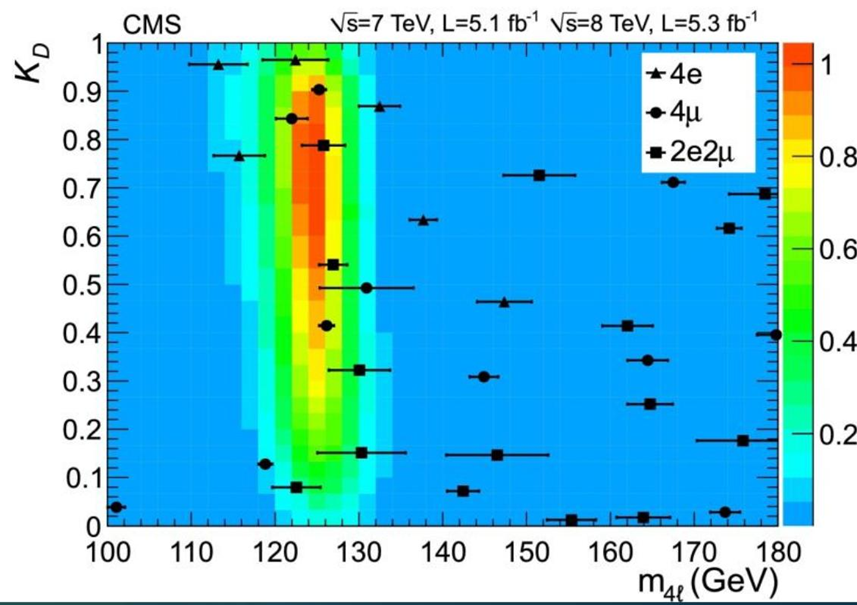

# Observables in Physics
**We are experimentalists** - we need observables to help differentiate signal from background! The matrix element method was crucial to the discovery of the Higgs boson, as it allowed for an efficient observable to be crafted to allow for this.

This is doubly important in EFT, where effects are small enough where we can't do noticeable bump searches from the naked eye!

/tmp/ipykernel_583840/340433839.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


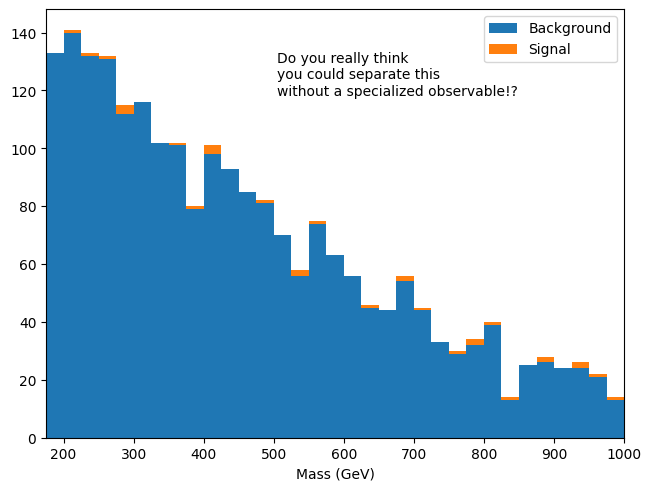

In [7]:
fig, ax = plt.subplots(1,1,layout="constrained")
EFT_signal = np.random.uniform(175, 1000, 30) #Imagine a rare EFT process that is seen above the top mass
background = 175 + 1000*np.random.exponential(0.4, 2500) #some random falling background
binning = np.arange(175, 1001, 25)

background_counts, _ = np.histogram(background, binning)
EFT_signal_counts, _ = np.histogram(EFT_signal, binning)

hep.histplot(
    [background_counts, EFT_signal_counts], binning, 
    stack=True, label=["Background", "Signal"], ax=ax,
    histtype='fill'
)
ax.set_xlim(175, 1000)
ax.set_xlabel("Mass (GeV)")
ax.text(0.4, 0.8, "Do you really think\nyou could separate this\nwithout a specialized observable!?", transform=plt.gca().transAxes)
ax.legend()
fig.show()

# Quantifying Separation

We can *say* that we could not differentiate signal and background well, but how do we quantify it *quickly*? We can use a ROC curve! 

## ROC Curves

Receiver-Operating-Characteristic curves display the ability of a given observable to separate 2 different hypotheses, but purely in terms of the shape, and were borne out of WWII, arising out of a need to distinguish aircraft from noise for radar operators. 

They are defined by the relationship between the "True Positive" rate and the "False Positive" Rate at a given cut in the phase-space. Here is the procedure for creating one:

1. Sort your distribution in terms of greatest to least of signal/background
2. Iterate over the bin values in signal and background concurrently
3. Within each iteration, determine the TPR and FPR for your histogram, with all bins above and including the current bin (C) designated as "signal" (S), and all those below "background" (B). They are determined using the following formulas:

$$ 
TPR(C) = \displaystyle\frac{\displaystyle\sum_{i=C}^{n} A_i}{\displaystyle\sum_{i=0}^{n} A_i} 
\qquad\qquad
FPR(C) = \displaystyle\frac{\displaystyle\sum_{i=C}^{n} B_i}{\displaystyle\sum_{i=0}^{n} B_i}
$$

4. Now plot TPR versus FPR
5. The metric to use is now the area between the diagonal and the curve, or 0.5 minus the area underneath the curve.

### ROC Disclaimers

ROC curves will make an implicit assumption that both hypotheses are the same integral (WHICH IS VERY MUCH NOT THE CASE HERE), as the curve is really only measuring shape differences. So, in this case, the "seperability metric" is a huge overestimate. So why do we use them?? It is a good tool to **compare the performance of different observables when comparing the same 2 distributions**.

**ROC Curves are also really weird when dealing with negative weights - so while we will discuss observables that are uniquely sensitive to interference, we will not be applying ROC curves to those (in some cases)**.

## Exercise 1: Plot what the ROC curve is actually seeing!

Make the integral of both `EFT_signal_counts` and `background_counts` equal to 1 and plot it in the same way as above to check out what you're actually doing!

AssertionError: 

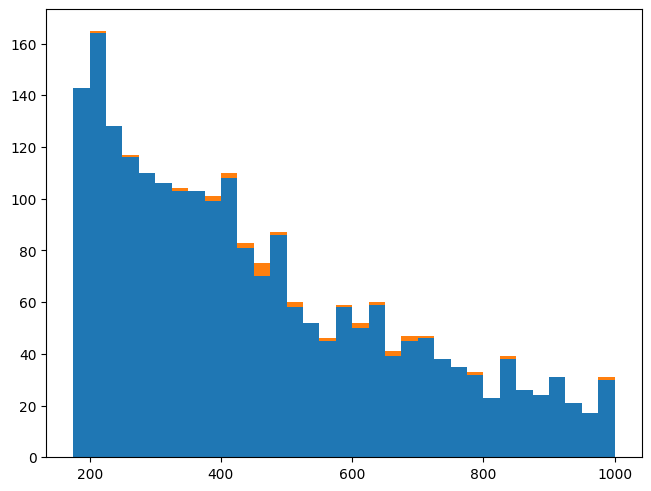

In [93]:
fig, ax = plt.subplots(1,1,layout="constrained")

scaled_bkg_counts = background_counts.copy() #FIX THIS!
scaled_EFT_counts = EFT_signal_counts.copy() #FIX THIS!

hep.histplot(
    [scaled_bkg_counts, scaled_EFT_counts], binning, 
    stack=True, label=["Background", "Signal"], ax=ax,
    histtype='fill'
)
assert round(scaled_bkg_counts.sum(), 4) == round(scaled_EFT_counts.sum(), 4)

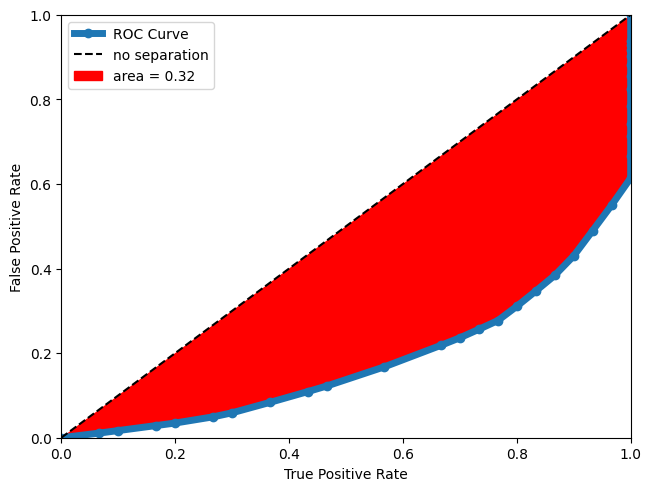

In [8]:
def ROC_curve(signal, background):
    ratios = np.argsort(signal/background)[::-1]
    PAC = np.zeros(len(signal) + 1)
    NAC = np.zeros(len(signal) + 1)
    
    PAC[1:] = np.cumsum(signal[ratios]) #positive above cut
    NAC[1:] = np.cumsum(background[ratios]) #negative above cut

    TPR = PAC/(signal.sum())
    FPR = NAC/(background.sum())


    return TPR, FPR, np.abs(np.trapz(FPR, TPR))

fig, ax = plt.subplots(1,1, layout="constrained")
TPR, FPR, score = ROC_curve(EFT_signal_counts, background_counts)
ax.plot(TPR, FPR, lw=5, marker='o', label="ROC Curve")
ax.axline((0,0), (1,1), color='k', linestyle='dashed', label="no separation")
ax.fill_between(TPR, TPR, FPR, color='red', label=f"area = {0.5 - score:.2f}")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("True Positive Rate")
ax.set_ylabel("False Positive Rate")
ax.legend()

# Let's make a "fake" observable that we can convolute together

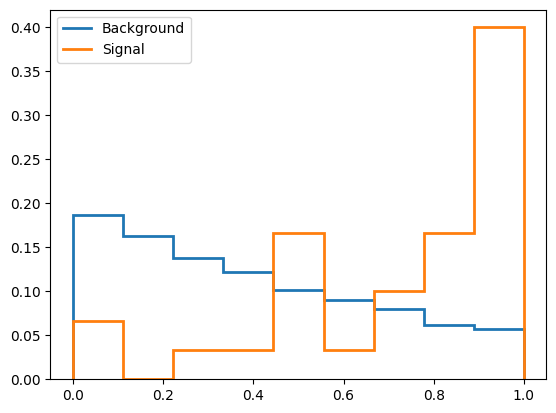

In [9]:
EFT_signal_obs = np.zeros(30)
background_obs = np.zeros(2500)

for i in range(2500):
    if i < 30:
        temp_val = -1
        while (temp_val < 0 or temp_val > 1):
            temp_val = 1 - np.random.exponential(0.3) #Imagine a rare EFT process that is seen above the top mass
        EFT_signal_obs[i] = temp_val
    
    temp_val = -1
    
    while (temp_val < 0 or temp_val > 1):
        temp_val = np.random.exponential(0.7)
    background_obs[i] = temp_val

# background_obs = np.maximum(0, np.random.exponential(0.7, 2500)) #some random falling background
binning_obs = np.linspace(0, 1, 10)

background_counts_obs, _ = np.histogram(background_obs, binning_obs)
EFT_signal_counts_obs, _ = np.histogram(EFT_signal_obs, binning_obs)

hep.histplot(
    [background_counts_obs/background_counts_obs.sum(), EFT_signal_counts_obs/EFT_signal_counts_obs.sum()], binning_obs, 
    stack=False, label=["Background", "Signal"],
    histtype='step', lw=2
)
plt.legend()

convoluted_background, *_ = np.histogram2d(background, background_obs, [binning, binning_obs])
convoluted_EFT_signal, *_ = np.histogram2d(EFT_signal, EFT_signal_obs, [binning, binning_obs])

the ROC Curve function only really works with 1-dimensional binnings. Luckily, the same information is contained if we **unravel** any N-Dimensional histogram into a 1-dimensional object, as shown below using `np.ravel`. This is what is done for input into Higgs Combine for analyses with multidimensional histograms that are inputs!

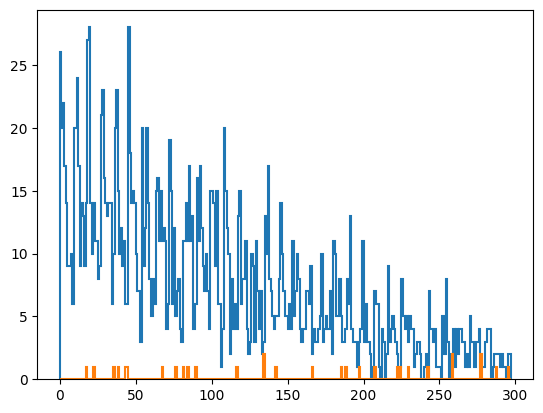

In [10]:
hep.histplot([convoluted_background.ravel(), convoluted_EFT_signal.ravel()]);

Utilizing our `convoluted_background` and `convoluted_EFT_signal` objects, plot ROC curves comparing the efficacy of just the observable, just the mass distribution, and the combination of the two! The mass distribution is done for you. **Which one performs the best?**

/tmp/ipykernel_583840/3468028132.py:2: RuntimeWarning: divide by zero encountered in divide
  ratios = np.argsort(signal/background)[::-1]
/tmp/ipykernel_583840/3468028132.py:2: RuntimeWarning: invalid value encountered in divide
  ratios = np.argsort(signal/background)[::-1]


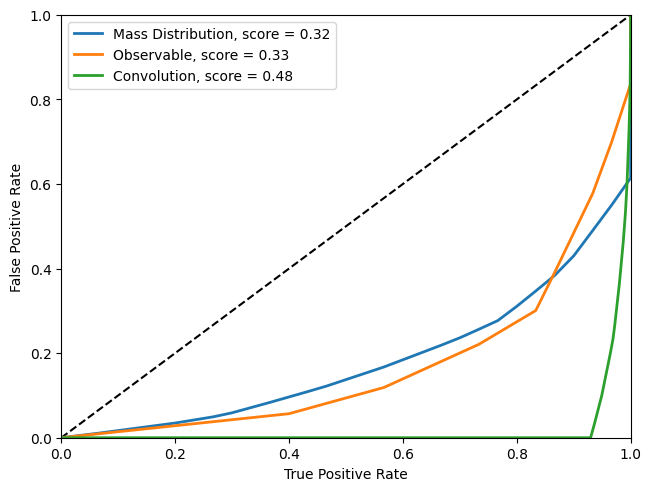

In [11]:
fig, ax = plt.subplots(1,1, layout="constrained")
ax.axline((0,0), (1,1), linestyle="dashed", color='k')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

TPR, FPR, score = ROC_curve(EFT_signal_counts, background_counts)
ax.plot(TPR, FPR, lw=2, label=f"Mass Distribution, score = {0.5 - score:.2f}")

TPR, FPR, score = ROC_curve(EFT_signal_counts_obs, background_counts_obs)
ax.plot(TPR, FPR, lw=2, label=f"Observable, score = {0.5 - score:.2f}")

TPR, FPR, score = ROC_curve(convoluted_background.ravel(), convoluted_EFT_signal.ravel())
ax.plot(TPR, FPR, lw=2, label=f"Convolution, score = {0.5 - score:.2f}")

ax.set_xlabel("True Positive Rate")
ax.set_ylabel("False Positive Rate")
ax.legend()

# Initializing Your MELA Object

The MELA object is available in both Python and in C++. Both are pre-compiled libraries, with the Python library utilizing PyBind11 in order to create the bindings, which have been available as of July 2024. There are also a slew of other things stored in the Mela Python library, which we will go over!

**For more on documentation with MELA, please go to the other portion of this tutorial in the other notebook**

**Note that there is documentation for JHUGenMELA that is located [on the website](https://spin.pha.jhu.edu/MELA/). Everything that we will be doing pertains to the section called [PyMela](https://spin.pha.jhu.edu/MELA/PyMela_page.html)**.

**We will be referring back to this documentation *constantly*! So please familiarize yourself with it**

In [12]:
import Mela

The constructor can be found [here](https://spin.pha.jhu.edu/MELA/MELA_python.html) in Python as an example, with the underlying C++ function found [here](https://spin.pha.jhu.edu/MELA/classMela.html#aa0d92c0d836f7c720f584dc75a8031fc). **Note that all the actual function signatures are documented within the C++ area, as that is where the functions are actually defined**.

In [13]:
#MELA is initialized as (Center-of-Mass Energy, Higgs Mass, Verbosity)
m = Mela.Mela(13, 125, Mela.VerbosityLevel.SILENT)

*****************************************************************************************************
*                             MELA (Matrix Element Likelihood Approach)                             *
*****************************************************************************************************
*                                                                                                   *
*                           Data analysis and Monte Carlo weights package                           *
*         for analyses of resonances produced at pp, ppbar, and e+e- colliders, featuring:          *
*                                                                                                   *
*                                          * JHUGenMELA *                                           *
*     Signal calculations based on analytical pdf.s, and JHU Generator (JHUGen) matrix elements     *
*                                    (See JHUGen credits below)                   

  *               Phys.Rev. D81 (2010) 075022;  arXiv:1001.3396  [hep-ph],                *
  *               Phys.Rev. D86 (2012) 095031;  arXiv:1208.4018  [hep-ph],                *
  *               Phys.Rev. D89 (2014) 035007;  arXiv:1309.4819  [hep-ph],                *
  *               Phys.Rev. D94 (2016) 055023;  arXiv:1606.03107 [hep-ph],                *
  *               Phys.Rev. D102 (2020) 056022; arXiv:2002.09888 [hep-ph],                *
  *               Phys.Rev. D102 (2021) 055045; arXiv:2104.04277 [hep-ph].                *
  *               Phys.Rev. D105 (2022) 096027; arXiv:2109.13363 [hep-ph].                *
  *                                                                                       *
  *****************************************************************************************
  
 JHUGen CKM initialization
 Vud =   0.97428499999999996     
 Vus =   0.22528999999999999     
 Vub =    3.6269374133152273E-003
 Vcd =  -0.22518199999999999     
 Vcs =

# What kinds of observables can we see initially?

Well, if we don't construct anything else, then we can craft observables that are derived directly from computations of the 4-vectors. If you remember from the first tutorial on MELA re-weighting, there are 8 key observables in every $H\rightarrow VV$ vertex! There also exist angles from other production modes that you can find!

**These angles can also be defined for more generally for spin-1 particles, as showcased in the [CMS analysis on the spin and parity of an all-charm tetraquark candidate](https://cms-results.web.cern.ch/cms-results/public-results/preliminary-results/BPH-24-002/index.html), and the subsequent [CERN plenary talk](https://indico.cern.ch/event/1533044/)**.

These are:
- $m_1$, or the mass of the largest spin-1 particle
- $m_2$, or the mass of the other particle
- 6 decay angles defined [here](https://arxiv.org/pdf/1208.4018)

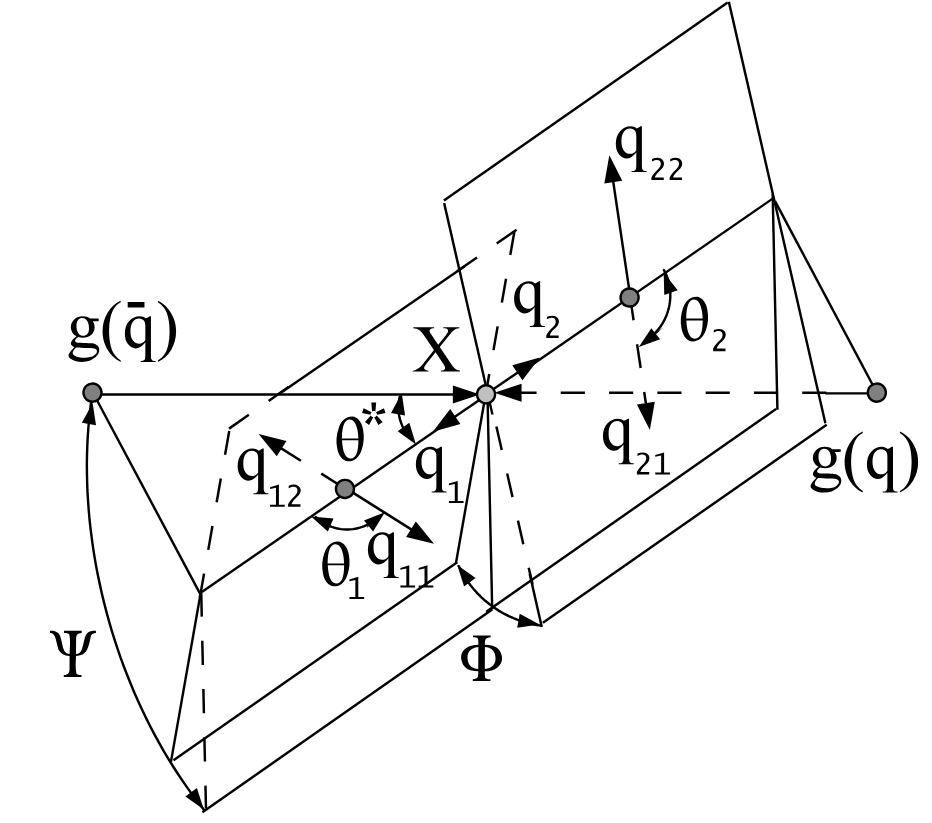

# Showcasing the strength of observables

Let's compare the strength of every observable to differentiate pure CP-odd, and pure CP-even terms. **"PS" indicates "Pseudoscalar" tensor structures for HVV couplings, which exhibit CP-odd behavior in the Higgs Amplitude Basis**.

First we should re-weight our distributions to these hypotheses, then check the efficacy of comparing the 2 distributions. **For the sake of visualization, let's also normalize all of these to have the same integral, so we can see exactly what the ROC curve will be visualizing**.

In [75]:
coupling_setups = {
    "SM":{"ghg2":[1,0], "ghz1":[1,0]},
    "PS":{"ghg2":[1,0], "ghz4":[1,0]},
    "PS_SM_pos" : {"ghg2":[1,0], "ghz1":[1,0], "ghz4":[1,0]},
    "PS_SM_neg" : {"ghg2":[1,0], "ghz1":[1,0], "ghz4":[-1,0]}
}

input_data = []

with uproot.open("SAMPLE/SM_Higgs.root") as f_in:
    data = f_in['tree'].arrays([
        "LHEMotherId",
        "LHEMotherPz",
        "LHEMotherE",
        
        
        "LHEDaughterId",
        "LHEDaughterPt",
        "LHEDaughterEta",
        "LHEDaughterPhi",
        "LHEDaughterMass"
    ])
    for i in tqdm.tqdm(range(len(data)), desc="pre-processing events"):
        mothers = Mela.SimpleParticleCollection_t(
            data["LHEMotherId"][i],
            [0]*len(data["LHEMotherId"][i]),
            [0]*len(data["LHEMotherId"][i]),
            data["LHEMotherPz"][i],
            data["LHEMotherE"][i],
            False
        )
        daughters = Mela.SimpleParticleCollection_t(
            data["LHEDaughterId"][i],
            data["LHEDaughterPt"][i],
            data["LHEDaughterEta"][i],
            data["LHEDaughterPhi"][i],
            data["LHEDaughterMass"][i],
            True
        )
        associated = None
        input_data.append(
            (daughters, None, mothers)
        )
    del data

pre-processing events:   0%|                                                                                          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_583840/2739734084.py:24: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mothers = Mela.SimpleParticleCollection_t(
/tmp/ipykernel_583840/2739734084.py:32: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  daughters = Mela.SimpleParticleCollection_t(
pre-processing events: 100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 651.87it/s]


In [76]:
template_arr = np.zeros(len(input_data), dtype=np.float64)
probabilities = {
    i : template_arr.copy() for i in coupling_setups.keys()
}

observables = np.zeros((8, len(input_data)), dtype=np.float64)
observable_names = "mH", "m1", "m2", "cos1", "cos2", "phi", "cos_star", "phi1"

for i, input_event in tqdm.tqdm(enumerate(input_data), desc="reweighting", total=len(input_data)):
    m.setInputEvent(*input_event) #There's a reason we ordered it like we did!
    m.setProcess(Mela.Process.SelfDefine_spin0, Mela.MatrixElement.JHUGen, Mela.Production.ZZGG)
    
    for name, coupling_dict in coupling_setups.items():
        if name == "bkg":
            m.setProcess(Mela.Process.bkgZZ, Mela.MatrixElement.MCFM, Mela.Production.ZZGG)
            
        for coup_name, coup_val in coupling_dict.items():
            setattr(m, coup_name, coup_val)
        
    
        probabilities[name][i] = m.computeP(False)
    
    observables[:,i] = m.computeDecayAngles()
    
    
    m.resetInputEvent()
    

reweighting: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3070.69it/s]


/tmp/ipykernel_583840/1893969217.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_583840/1893969217.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_583840/1893969217.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_583840/1893969217.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_583840/1893969217.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_583840/18939692

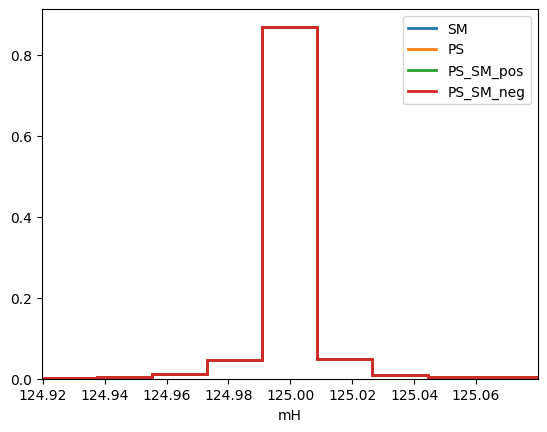

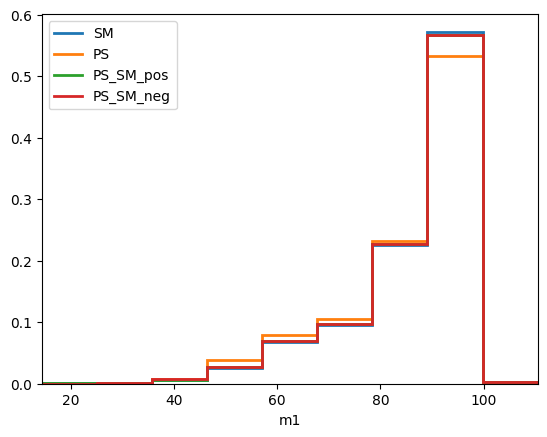

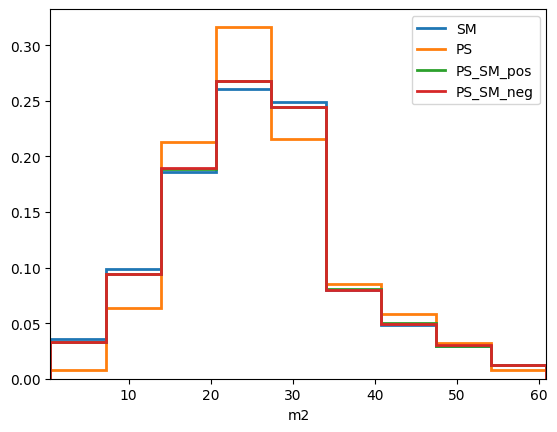

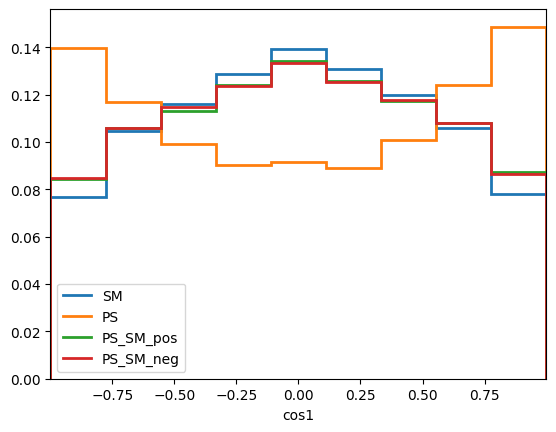

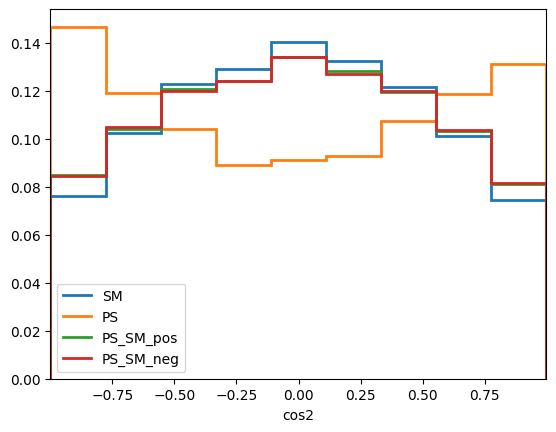

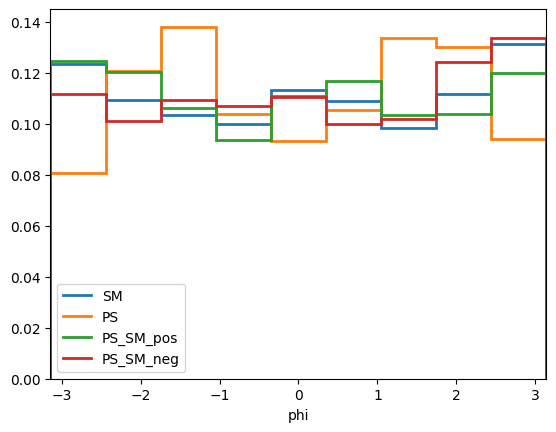

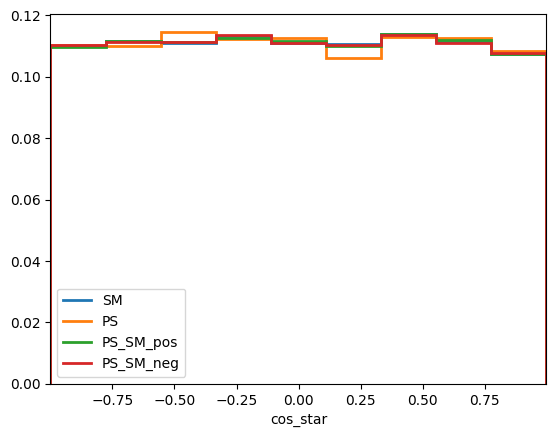

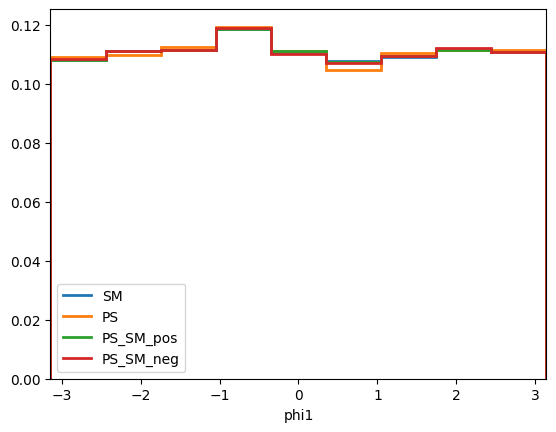

In [77]:
for i, name in enumerate(observable_names):
    fig, ax = plt.subplots(1,1)
    mini, maxi = observables[i].min(), observables[i].max()
    binning = np.linspace(mini, maxi, 10)
    plt.xlim(binning[0], binning[-1])
    
    for hypo, values in probabilities.items():
        prob = probabilities[hypo]
        counts, _ = np.histogram(
            observables[i], binning,
            weights=prob/probabilities["SM"]
        )
        counts = counts/counts.sum()
        hep.histplot(counts, binning, label=hypo, lw=2)
    
    ax.legend()
    ax.set_xlabel(name)
    fig.show()
    

Using the distributions shown here, please plot the ROC curve for separating "CP-odd" "pseudoscala" (PS) signal from our "background", Standard-Model (SM) expectation.

/tmp/ipykernel_583840/1086641241.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


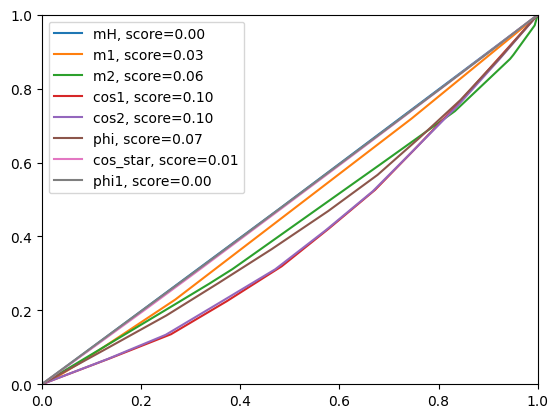

In [78]:
fig, ax = plt.subplots(1,1)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
scores = []
binnings = []
TPR_FPR_combos = []

for i, name in enumerate(observable_names):
    mini, maxi = observables[i].min(), observables[i].max()
    binning = np.linspace(mini, maxi, 10)
    binnings.append(binning)
    SM, _ = np.histogram(
        observables[i], 10
    )
    PS, _ = np.histogram(
        observables[i], 10,
        weights=probabilities["PS"]/probabilities["SM"]#np.zeros(len(observables[i])) #FIX THIS!
    )
    
    TPR, FPR, score = ROC_curve(PS, SM)
    ax.plot(TPR, FPR, label=f"{name}, score={0.5 - score:.2f}")
    scores.append(0.5 - score)
    TPR_FPR_combos.append((TPR, FPR))

ax.legend()
fig.show()
assert round(np.max(scores),2) == 0.1


# Results

So, some observables are **better** than others - but what if we **combined** every observable together into a Frankenstein's super-observable. Let's check the performance of that!

/tmp/ipykernel_583840/3468028132.py:2: RuntimeWarning: invalid value encountered in divide
  ratios = np.argsort(signal/background)[::-1]


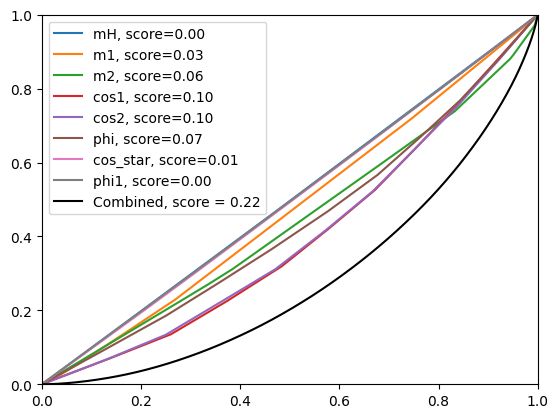

In [79]:
giga_SM, *_ = np.histogramdd( #5 bins per histogram
    observables.T,
    5
)
giga_PS, *_ = np.histogramdd(
    observables.T,
    5,
    weights=probabilities["PS"]/probabilities["SM"]
)

TPR, FPR, score = ROC_curve(giga_SM.ravel(), giga_PS.ravel())
ax.plot(TPR, FPR, label=f"Combined, score = {0.5 - score:.2f}", color='k')
ax.legend()
fig

**I AFFIRM - THIS MAKES SENSE AS TO WHY THINGS LOOK LIKE THIS**

IF IT DOES NOT MAKE SENSE ASK!!!!!!!!

In [25]:
affirmation = False
assert affirmation

AssertionError: 

# With our powers combined....

Combining all the observables gets us a better result, but we don't use this because it's an **absurd** number of bins - it's $5^8 \approx 390,000$ bins!!!!!!!!! We need something to engage in dimensionality reduction.

## Enter the Matrix Element

Matrix Elements encode the likelihood for all of these angles such that you don't have to convolute all of these bins, making for a much more stable analysis. **You can see them described in detail in the [LHC EFT WG Report](https://arxiv.org/abs/2211.08353)**. Remember that matrix elements describe a likelihood - which according to the [Neyman-Pearson Lemma](https://en.wikipedia.org/wiki/Neyman%E2%80%93Pearson_lemma) is the best possible discriminator one could possibly have!

### The 2 types of observable

There are 2 types of matrix-element observable that you can create, one sensitive to the pure tensor structure (i.e. $g_1^{VV}, g_4^{VV}$, etc.), and the other sensitive to interference between 2 hypotheses. Taken from the equations 4 and 5 LHC EFT WG Report linked above, they look as such, where $\vec{x}$ is the total reconstruction 4-vectors, and $c$ is some constant (which is chosen for convenience):

$$ D_{12}^{pure} = \frac{P_1(\vec{x})}{P_0(\vec{x})+ c \cdot P_1(\vec{x})} $$


$$ D_{12}^{int}  = \frac{2\cdot\left(P_{1,0}(\vec{x}) - P_1(\vec{x}) - P_0(\vec{x})\right)}{P_0(\vec{x}) + c \cdot P_1(\vec{x})} $$


### We first need to re-construct our probabilities without using the gen-level initial-state parton information by re-making our matrix-elements!

These create our distributions - which we can then **re-weight with our gen-level information from earlier**. 

## While the calculation stems from the same program, and sometimes are even the same values, you should separate them internally.

It will often be the case that we will construct the discriminants with our reco weights, then re-weight the sample to look like on hypothesis or the other. These are nominally different things!

In [80]:
def discr_pure(P0, P1, c):
    return P0/(P0 + c*P1)

def discr_int(P01, P0, P1, c):
    return (P01 - P0 - P1)/(P0 + c*P1)

def discr_int_mult(P01, P0, P1):
    return (P01 - P0 - P1)/(2*np.sqrt(P0*P1))

In [81]:
input_data_reco = []

with uproot.open("SAMPLE/SM_Higgs.root") as f_in:
    data = f_in['tree'].arrays([
        "LHEMotherId",
        "LHEMotherPz",
        "LHEMotherE",
        
        "LHEDaughterId",
        "LHEDaughterPt",
        "LHEDaughterEta",
        "LHEDaughterPhi",
        "LHEDaughterMass"
    ])
    for i in tqdm.tqdm(range(len(data)), desc="pre-processing events"):
        mothers = None
        daughters = Mela.SimpleParticleCollection_t(
            data["LHEDaughterId"][i],
            data["LHEDaughterPt"][i],
            data["LHEDaughterEta"][i],
            data["LHEDaughterPhi"][i],
            data["LHEDaughterMass"][i],
            True
        )
        associated = None
        input_data_reco.append(
            (daughters, None, None)
        )
    del data

pre-processing events:   0%|                                                                                          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_583840/2877326989.py:17: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  daughters = Mela.SimpleParticleCollection_t(
pre-processing events: 100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1082.01it/s]


In [82]:
template_arr = np.zeros(len(input_data), dtype=np.float64)
probabilities_reco = {
    i : template_arr.copy() for i in coupling_setups.keys()
}

for i, input_event in tqdm.tqdm(enumerate(input_data_reco), desc="reweighting", total=len(input_data)):
    m.setInputEvent(*input_event) #There's a reason we ordered it like we did!
    
    # change production mode to be production-independent
    m.setProcess(Mela.Process.SelfDefine_spin0, Mela.MatrixElement.JHUGen, Mela.Production.ZZGG)
    
    for name, coupling_dict in coupling_setups.items():   
        for coup_name, coup_val in coupling_dict.items():
            setattr(m, coup_name, coup_val)
        
        probabilities_reco[name][i] = m.computeP(False)
    
    m.resetInputEvent()
    

reweighting: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3063.97it/s]


# Let's take this term-by-term, starting with $g_1^{ZZ}$ VS $g_4^{ZZ}$

Since this is a pure term, let's construct the observable and compare it to all the angles independently.


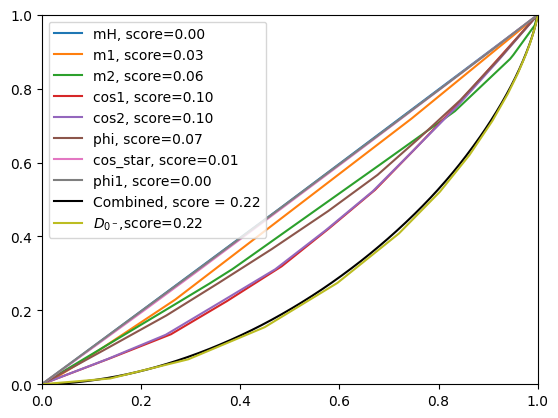

In [83]:
discr = discr_pure(probabilities_reco["SM"], probabilities_reco["PS"], 1)
discr_SM, discr_binning = np.histogram(discr, 20)
discr_PS, _ = np.histogram(discr, discr_binning, weights=probabilities["PS"]/probabilities["SM"])
TPR, FPR, score = ROC_curve(discr_SM, discr_PS)
ax.plot(TPR, FPR, label=r"$D_{0^-}$" + f",score={0.5 - score:.2f}")
ax.legend()
fig

# W O W !

With just 20 bins, which is 0.00002% of 10^8, we achieve the same level of separation! Let's look at the distribution as the ROC curve sees it.

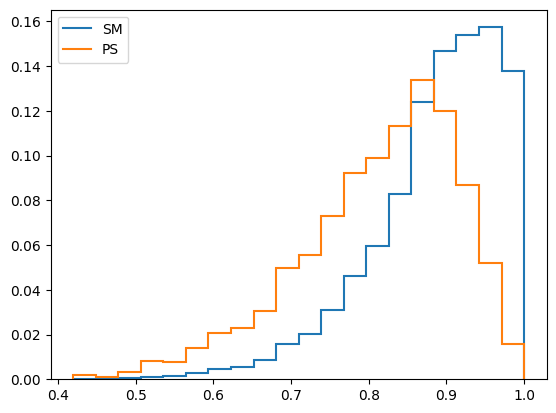

In [84]:
discr = discr_pure(probabilities_reco["SM"], probabilities_reco["PS"], 1) #np.mean(probabilities["SM"]/probabilities["PS"])
discr_SM, discr_binning = np.histogram(discr, 20)
discr_PS, _ = np.histogram(discr, discr_binning, weights=probabilities["PS"]/probabilities["SM"])
TPR, FPR, score = ROC_curve(discr_SM, discr_PS)

hep.histplot(discr_SM/discr_SM.sum(), discr_binning, label="SM")
hep.histplot(discr_PS/discr_PS.sum(), discr_binning, label="PS")
plt.legend()

# Utilizing the entire possible range

**In a real experimental setting, we don't know before-hand what the discriminant should look like, so we tend to bin it from 0-1 (either extreme of the discriminant), with the c-constant tuned such that at 0.5 ~50% of the background is below the cut and ~50% of the signal is above the cut.**

This makes for a better discriminant that is **less suscepible to fluctuations**, as if a discriminant is squished towards one end or another, it makes binning the distribution and finding a meaninful cut that much harder! **If you want proof, try changing the c-constant above to a very small number, or a very large number, and see what happens**.

The information is always the same, but here let's try and make the binning more concrete by tuning the c-constant!

/tmp/ipykernel_583840/3468028132.py:2: RuntimeWarning: invalid value encountered in divide
  ratios = np.argsort(signal/background)[::-1]


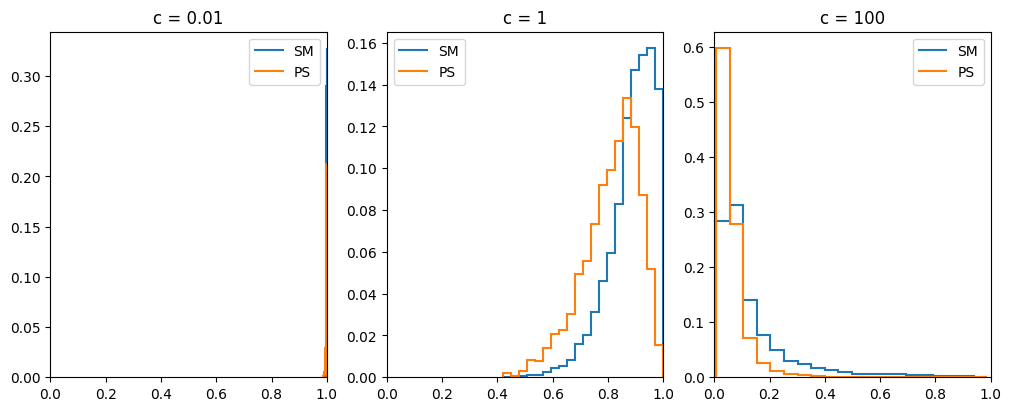

In [85]:
fig, axs = plt.subplots(1,3,layout="constrained", figsize=(10,4))

for i, c_constant in enumerate((0.01, 1, 100)):
    discr = discr_pure(probabilities_reco["SM"], probabilities_reco["PS"], c_constant)
    discr_SM, discr_binning = np.histogram(discr, 20)
    discr_PS, _ = np.histogram(discr, discr_binning, weights=probabilities["PS"]/probabilities["SM"])
    TPR, FPR, score = ROC_curve(discr_SM, discr_PS)

    hep.histplot(discr_SM/discr_SM.sum(), discr_binning, ax=axs[i], label="SM")
    hep.histplot(discr_PS/discr_PS.sum(), discr_binning, ax=axs[i], label="PS")
    axs[i].set_xlim(0,1)
    axs[i].set_title(f"c = {c_constant}")
    axs[i].legend()

In [86]:
def search(index_up, index_down, bkg, sig): #finds the index point utilizing a binary search
    
    index = (index_up + index_down)//2
    
    frac1 = np.sum(bkg[:index])/np.sum(bkg)
    frac2 = np.sum(sig[index:])/np.sum(sig)
    
    if index_up == index_down or abs(index_up - index_down) == 1:
        return index
    
    if frac1 < frac2:
        return search(index_up, index, bkg, sig)
    else:
        return search(index, index_down, bkg, sig)


In [120]:
initial_binning = np.linspace(0,1,1001) # really finely bin here to get granularity
bin_centers = (initial_binning[1:] + initial_binning[:-1])/2

#make an initial guess using 1
discr = discr_pure(probabilities_reco["SM"], probabilities_reco["PS"], 1)
discr_SM, _ = np.histogram(discr, initial_binning)
discr_PS, _ = np.histogram(discr, initial_binning, weights=probabilities["PS"]/probabilities["SM"])

R = bin_centers[search(len(bin_centers), 0, discr_SM, discr_PS)]

c_constant_calculated = 1/( (1/R) - 1 )
print(c_constant_calculated)


6.662835249042139


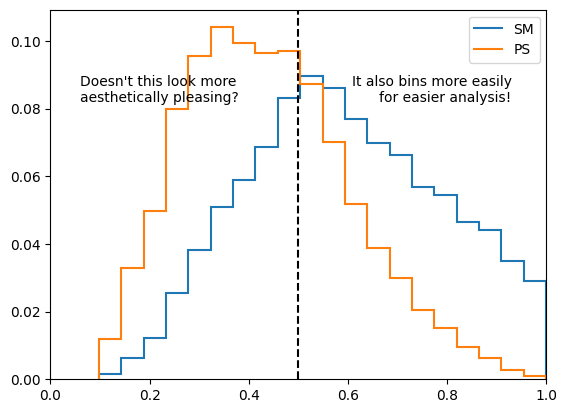

In [121]:
discr = discr_pure(probabilities_reco["SM"], probabilities_reco["PS"], c_constant_calculated)
discr_SM, discr_binning = np.histogram(discr, 20)
discr_PS, _ = np.histogram(discr, discr_binning, weights=probabilities["PS"]/probabilities["SM"])
TPR, FPR, score = ROC_curve(discr_SM, discr_PS)

hep.histplot(discr_SM/discr_SM.sum(), discr_binning, label="SM")
hep.histplot(discr_PS/discr_PS.sum(), discr_binning, label="PS")
plt.gca().axvline(0.5, linestyle="dashed", color='k')
plt.xlim(0,1)
plt.gca().text(0, 0.7, "Doesn't this look more\naesthetically pleasing?", transform=ax.transAxes, ha='left')
plt.gca().text(0.87, 0.7, "It also bins more easily\nfor easier analysis!", transform=ax.transAxes, ha='right')
plt.legend()

# What is the input to computeP?????

The input is whether or not you want to add the "reconstruction spline" to the probability. This is simply a value that comes from a pre-computed c-constant spline and is multiplied into the probability. This sometimes makes it a lot easier to make discriminants as you don't have to tune the discriminant like we did just now.

## If you want, change the "False" to "True" in computeP and check it out

Check below to affirm your understanding

In [ ]:
affirmation = ""
assert affirmation = "I affirm"

# Let's now look at the case with interference!

Here we are going to separate the sign of the interference pattern. If you recall from our setup, we have 2 sets of probabilities where there is a mixture of CP-even and CP-odd tensor structures:

- $P_\text{ghz1=1,ghz4=1}$
- $P_\text{ghz1=1,ghz4=-1}$

Since amplitudes go as the coupling squared, the "pure" discriminant can't differentiate to be sensitive to the sign, as the "pure" terms between $|g_1^{ZZ} + g_4^{ZZ}|^2$ and $|g_1^{ZZ} - g_4^{ZZ}|^2$ are exactly the same. **If you want an explanation as to why there are negative weights in interference, and how that arises, please consult the re-weighting tutorial**.

/tmp/ipykernel_583840/3468028132.py:2: RuntimeWarning: invalid value encountered in divide
  ratios = np.argsort(signal/background)[::-1]


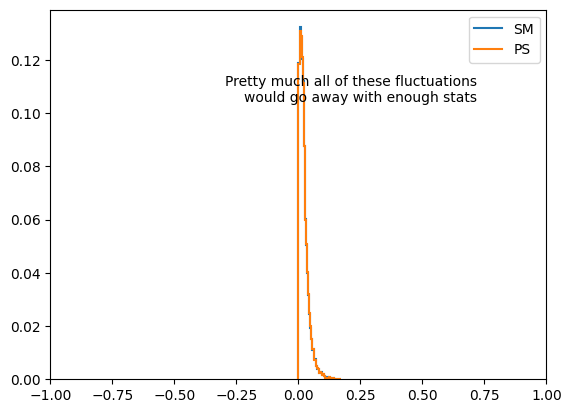

In [127]:
discr = discr_pure(probabilities_reco["PS"], probabilities_reco["SM"], c_constant_calculated)
#This is our pure discriminant, but we will utilize it for events that look like positive and negative interference

discr_SM, discr_binning = np.histogram(discr, 40, weights=probabilities["PS_SM_pos"]/probabilities["SM"])
discr_PS, _ = np.histogram(discr, discr_binning, weights=probabilities["PS_SM_neg"]/probabilities["SM"])
TPR, FPR, score = ROC_curve(discr_SM, discr_PS)

hep.histplot(discr_SM/discr_SM.sum(), discr_binning, label="SM")
hep.histplot(discr_PS/discr_PS.sum(), discr_binning, label="PS")
plt.gca().text(
    0.8, 0.7, "Pretty much all of these fluctuations\nwould go away with enough stats", 
    transform=ax.transAxes, ha='right'
)
plt.xlim(-1,1)
plt.legend()

In [137]:
1/2.55**2

0.15378700499807768

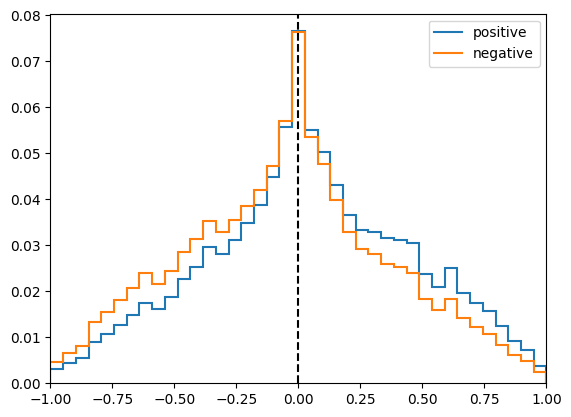

In [144]:
discr = discr_int(probabilities_reco["PS_SM_pos"], probabilities_reco["PS"], probabilities["SM"], 0.15)

discr_binning = np.linspace(-1, 1, 40)
discr_pos, _ = np.histogram(discr, discr_binning, weights=probabilities["PS_SM_pos"]/probabilities["SM"])
discr_neg, _ = np.histogram(discr, discr_binning, weights=probabilities["PS_SM_neg"]/probabilities["SM"])
TPR, FPR, score = ROC_curve(discr_pos, discr_neg)

hep.histplot(discr_pos/discr_pos.sum(), discr_binning, label="positive")
hep.histplot(discr_neg/discr_neg.sum(), discr_binning, label="negative")
plt.xlim(-1,1)
plt.gca().axvline(0, linestyle='dashed', color='k')
plt.legend()

So, let's use the CP-sensitive discriminant here, which is sensitive to the interference term! 
Since we are constructing discriminants from different constructs here, we need to initially define our binning
from the get-go to be in the range $[-1,1]$. Here, notice how the discriminant is symmetric around 1. The c-constant will just stretch the discriminant out!

/tmp/ipykernel_583840/3468028132.py:2: RuntimeWarning: invalid value encountered in divide
  ratios = np.argsort(signal/background)[::-1]
/tmp/ipykernel_583840/3468028132.py:2: RuntimeWarning: invalid value encountered in divide
  ratios = np.argsort(signal/background)[::-1]


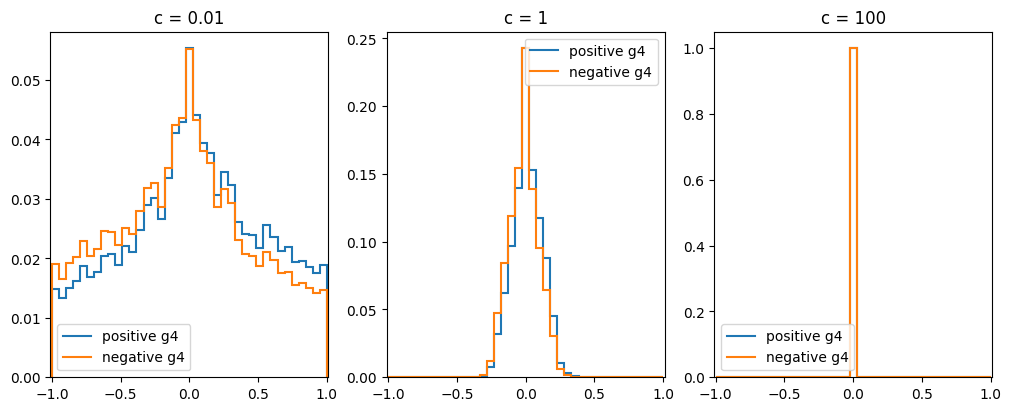

In [147]:
fig, axs = plt.subplots(1,3,layout="constrained", figsize=(10,4))

for i, c_constant in enumerate((0.01, 1, 100)):
    discr = discr_int(probabilities_reco["PS_SM_pos"], probabilities_reco["PS"], probabilities["SM"], c_constant)
    
    discr_binning = np.linspace(-1, 1, 40)
    discr_pos, _ = np.histogram(discr, discr_binning, weights=probabilities["PS_SM_pos"]/probabilities["SM"])
    discr_neg, _ = np.histogram(discr, discr_binning, weights=probabilities["PS_SM_neg"]/probabilities["SM"])
    TPR, FPR, score = ROC_curve(discr_pos, discr_neg)

    hep.histplot(discr_pos/discr_pos.sum(), discr_binning, ax=axs[i], label="positive g4")
    hep.histplot(discr_neg/discr_neg.sum(), discr_binning, ax=axs[i], label="negative g4")
    axs[i].set_xlim(-1.01,1.01)
    axs[i].set_title(f"c = {c_constant}")
    axs[i].legend()

/tmp/ipykernel_583840/3468028132.py:2: RuntimeWarning: invalid value encountered in divide
  ratios = np.argsort(signal/background)[::-1]


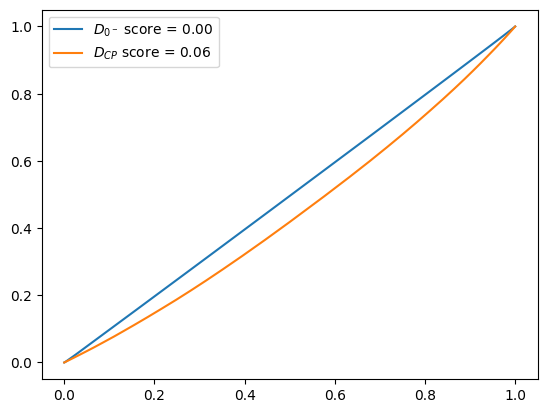

In [140]:
discr = discr_pure(probabilities_reco["PS"], probabilities_reco["SM"], c_constant_calculated)
#This is our pure discriminant, but we will utilize it for events that look like positive and negative interference

discr_SM, discr_binning = np.histogram(discr, 40, weights=probabilities["PS_SM_pos"]/probabilities["SM"])
discr_PS, _ = np.histogram(discr, discr_binning, weights=probabilities["PS_SM_neg"]/probabilities["SM"])
TPR, FPR, score = ROC_curve(discr_SM, discr_PS)
plt.plot(TPR, FPR, label=r"$D_{0^-}$" + f" score = {0.5 - score:.2f}")


discr = discr_int(probabilities_reco["PS_SM_pos"], probabilities_reco["PS"], probabilities["SM"], 0.15)
discr_binning = np.linspace(-1, 1, 40)
discr_pos, _ = np.histogram(discr, discr_binning, weights=probabilities["PS_SM_pos"]/probabilities["SM"])
discr_neg, _ = np.histogram(discr, discr_binning, weights=probabilities["PS_SM_neg"]/probabilities["SM"])
TPR, FPR, score = ROC_curve(discr_pos, discr_neg)
plt.plot(TPR, FPR, label=r"$D_{CP}$" + f" score = {0.5 - score:.2f}")

plt.legend()

#  To quote the [LHC EFT WG Text](https://arxiv.org/pdf/2211.08353#subsubsection.0.2.1.2):

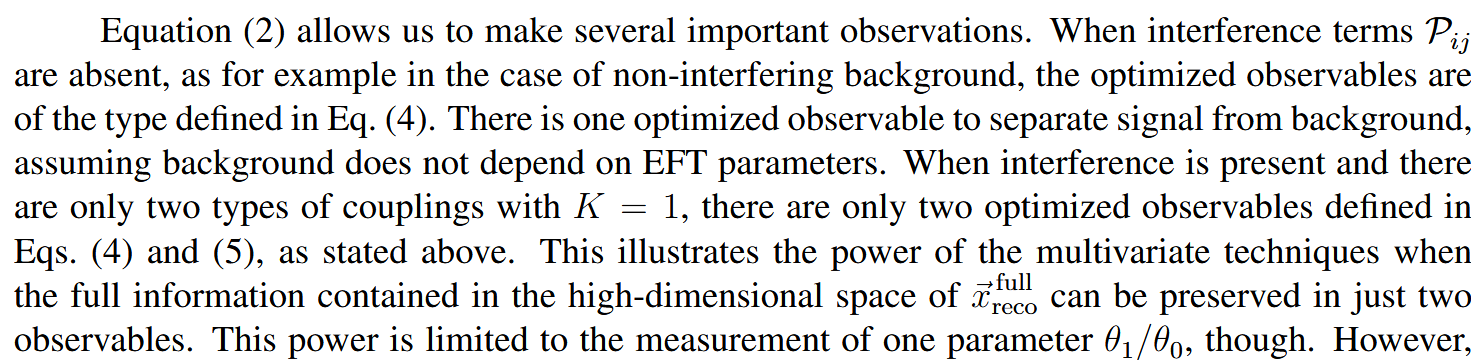

**where Equation 4 and 5 are the Equations for the discriminants (in the same order), and Equation 2 is a description of the sum of all possible amplitudes:**

$$ {\cal P}(\vec{x}_\mathrm{reco}|\vec{\theta})  \propto
{\cal P}_0(\vec{x}_\mathrm{reco}) 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
\nonumber  \\
+  \sum_{1\le k \le K} \left(\frac{2\theta_k}{\theta_0}\right) {\cal P}_{0k}(\vec{x}_\mathrm{reco}) 
+ \sum_{1\le k \le K} \left(\frac{\theta_k}{\theta_0}\right)^2 {\cal P}_k(\vec{x}_\mathrm{reco}) 
+ \sum_{1\le i<j\le K} \left(\frac{2\theta_i\theta_j}{\theta_{0}^2}\right) {\cal P}_{ij}(\vec{x}_\mathrm{reco}) $$

# Your final mission, should you choose to accept it

I want **you** to re-create $D_{bkg}^{kin}$, which utilizes the kinematics to separate out Higgs-like signals from the mess of $gg \rightarrow ZZ \rightarrow 4\ell$ background. I will calculate the relevant matrix-elements - it is up to you to utilize the text, pick the right kind of discriminant to use, and try and complete the tutorial!

In [124]:
SIG_BKG_GEN = {
    "SIG" : np.zeros(10000),
    "BKG" : np.zeros(10000)
}

SIG_BKG_RECO = {
    "SIG" : np.zeros(10000),
    "BKG" : np.zeros(10000)
}

for i, input_event in tqdm.tqdm(enumerate(input_data), desc="reweighting", total=len(input_data)):
    m.setInputEvent(*input_event) #There's a reason we ordered it like we did!
    m.setProcess(Mela.Process.HSMHiggs, Mela.MatrixElement.MCFM, Mela.Production.ZZGG)
    SIG_BKG_GEN["SIG"][i] = m.computeP(False)
    m.setProcess(Mela.Process.bkgZZ, Mela.MatrixElement.MCFM, Mela.Production.ZZGG)
    SIG_BKG_GEN["BKG"][i] = m.computeP(False)
    
    m.setInputEvent(*input_data_reco[i]) #There's a reason we ordered it like we did!
    m.setProcess(Mela.Process.HSMHiggs, Mela.MatrixElement.MCFM, Mela.Production.ZZGG)
    SIG_BKG_RECO["SIG"][i] = m.computeP(False)
    m.setProcess(Mela.Process.bkgZZ, Mela.MatrixElement.MCFM, Mela.Production.ZZGG)
    SIG_BKG_RECO["BKG"][i] = m.computeP(False)
    
    observables[:,i] = m.computeDecayAngles()
    
    
    m.resetInputEvent()


reweighting: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1885.29it/s]


# In Summary

Discriminants encode the information from all the observables that are derived from the 4-vectors utilizing the matrix-element values likelihoods, making them the best possible discriminator according to the Neyman-Pearson Lemma.

We can use different discriminants to do different things! 

## Combining the 2 types of discriminant into a 2-d observable makes them usable for practically every purpose!

This is often what is done in analyses sensitive to EFT effects in some way. For instance, in $H \rightarrow ZZ$, the 3 observables are (at least) $D_{bkg}$, $D_{bsi}$ (sensitive to interference between signal and background), and the mass spectrum.